In [1]:
# Import necessary dependencies
import sys
import os
import zipfile

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()

# Project directory
project_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(project_dir)

# Python file for custom functions
from src.utils import *

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Directory to your zipfile
ZIPFILE_PATH = os.path.join(project_dir, 'datasets', 'ICPSR_38925-V1.zip')

# Directories to the parquet files
DS0001 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/batch_header_extract_ds0001.parquet')
DS0002 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/admin_extract_ds0002.parquet')
DS0003 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/incident_extract_ds0003.parquet')
DS0004 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/victim_extract_ds0004.parquet')
DS0005 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/arrestee_extract_ds0005.parquet')
DS0006 = os.path.join(project_dir, 'datasets', 'ICPSR_38925/offender_extract_ds0006.parquet')

# Directory to your codebook
CODEBOOK_PATH = os.path.join(project_dir, '38925-Documentation-PI_Codebook.xlsx')  # extracted
# CODEBOOK_PATH = 'ICPSR_38925-V1/ICPSR_38925/38925-Documentation-PI_Codebook.xlsx'  # in the zipfile

In [3]:
# Access to zip file
czip = zipfile.ZipFile(ZIPFILE_PATH)
czip.namelist()

['ICPSR_38925-V1/',
 'ICPSR_38925-V1/ICPSR_38925/',
 'ICPSR_38925-V1/ICPSR_38925/38925-Documentation-PI_Codebook.xlsx',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/38925-0001-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0001/38925-0001-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/38925-0002-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/DS0002/38925-0002-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Data.tsv',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Documentation-readme_gzip.txt',
 'ICPSR_38925-V1/ICPSR_38925/DS0003/38925-0003-Codebook-ICPSR.pdf',
 'ICPSR_38925-V1/ICPSR_38925/38925-related_literature.txt',
 'ICPSR_38925-V1/ICPSR_38925/38925-manifest.txt',
 'ICPSR_38925-V1/ICPSR_38925/38925-descriptioncitation.html',
 'ICPSR_38925-V1/ICPSR_38925/TermsOfUse.html',
 'ICPSR_38925-V1/ICPSR_38925/DS0004/',
 'ICPSR_38925-V1/ICPSR_38925/DS0004/38925-0004-D

In [4]:
# Look up column names and data types
incident_schema = pl.read_parquet_schema(DS0003)
incident_schema

{'V40261': String,
 'ALLOFNS-ALL OFFENSE CODES FOR THE INCIDENT': String,
 'BH005-DATE ORI WAS ADDED': Datetime(time_unit='us', time_zone=None),
 'BH006-DATE ORI WENT NIBRS': Datetime(time_unit='us', time_zone=None),
 'BH007-CITY NAME': String,
 'BH008-STATE ABBREVIATION': String,
 'BH009-POPULATION GROUP': String,
 'BH010-COUNTRY DIVISION': String,
 'BH011-COUNTRY REGION': String,
 'BH012-AGENCY INDICATOR': String,
 'BH013-CORE CITY': String,
 'BH014-COVERED BY ORI': String,
 'BH015-FBI FIELD OFFICE': Int32,
 'BH016-JUDICIAL DISTRICT': String,
 'BH017-AGENCY NIBRS FLAG': String,
 'BH018-AGENCY INACTIVE DATE': Datetime(time_unit='us', time_zone=None),
 'BH019-CURRENT POPULATION 1': Int32,
 'BH020-UCR COUNTY CODE 1': Int32,
 'BH021-MSA CODE 1': Int32,
 'BH022-LAST POPULATION 1': Int32,
 'BH023-CURRENT POPULATION 2': Int32,
 'BH024-UCR COUNTY CODE 2': Int32,
 'BH025-MSA CODE 2': Int32,
 'BH026-LAST POPULATION 2': Int32,
 'BH027-CURRENT POPULATION 3': Int32,
 'BH028-UCR COUNTY CODE 3': In

In [5]:
# Columns with important data
important_data = [
    'STATE-NUMERIC STATE CODE', 'INCNUM-INCIDENT NUMBER', 'INCDATE-INCIDENT DATE',
    'BH007-CITY NAME', 'BH008-STATE ABBREVIATION', 'V1008-TOTAL OFFENSE SEGMENTS',
    'V1009-TOTAL VICTIM SEGMENTS', 'V1010-TOTAL OFFENDER SEGMENTS', 'V1011-TOTAL ARRESTEE SEGMENTS',
    'V20061-UCR OFFENSE CODE - 1', 'V20111-LOCATION TYPE - 1', 'V20141-TYPE CRIMINAL ACTIVITY/GANG INFO 1 - 1',
    'V20171-WEAPON / FORCE 1 - 1', 'V20201-BIAS MOTIVATION 1 - 1', 'V30121-SUSPECTED DRUG TYPE 1 - 1',
    'V40171-TYPE OF VICTIM-1', 'V40181-AGE OF VICTIM-1', 'V40191-SEX OF VICTIM-1',
    'V40201-RACE OF VICTIM-1', 'V40211-ETHNICITY OF VICTIM-1', 'V40221-RESIDENT STATUS OF VICTIM-1',
    'V40321-RELATIONSHIP VIC TO OFF 1-1', 'V50071-AGE OF OFFENDER - 1', 'V50081-SEX OF OFFENDER - 1',
    'V50091-RACE OF OFFENDER - 1', 'V50111-ETHNICITY OF OFFENDER - 1', 'V60081-ARREST DATE - 1',
    'V60121-ARRESTEE ARMED WITH 1 - 1', 'V60141-AGE OF ARRESTEE - 1', 'V60151-SEX OF ARRESTEE - 1',
    'V60161-RACE OF ARRESTEE - 1', 'V60171-ETHNICITY OF ARRESTEE - 1', 'V60181-RESIDENT STATUS OF ARRESTEE - 1',
    'V60191-DISPOSITION OF ARRESTEE UNDER 18 - 1'
]

In [6]:
# Filter incidents in Chicago, IL
chicago_incident_nibrs = pl.scan_parquet(
    DS0003,
).select(
    important_data
).filter(
    pl.col('BH008-STATE ABBREVIATION').is_in(['IL']),
    pl.col('BH007-CITY NAME').str.to_lowercase().str.contains('chicago'),
    pl.col('V60081-ARREST DATE - 1').dt.year() == 2022
).collect()
chicago_incident_nibrs

STATE-NUMERIC STATE CODE,INCNUM-INCIDENT NUMBER,INCDATE-INCIDENT DATE,BH007-CITY NAME,BH008-STATE ABBREVIATION,V1008-TOTAL OFFENSE SEGMENTS,V1009-TOTAL VICTIM SEGMENTS,V1010-TOTAL OFFENDER SEGMENTS,V1011-TOTAL ARRESTEE SEGMENTS,V20061-UCR OFFENSE CODE - 1,V20111-LOCATION TYPE - 1,V20141-TYPE CRIMINAL ACTIVITY/GANG INFO 1 - 1,V20171-WEAPON / FORCE 1 - 1,V20201-BIAS MOTIVATION 1 - 1,V30121-SUSPECTED DRUG TYPE 1 - 1,V40171-TYPE OF VICTIM-1,V40181-AGE OF VICTIM-1,V40191-SEX OF VICTIM-1,V40201-RACE OF VICTIM-1,V40211-ETHNICITY OF VICTIM-1,V40221-RESIDENT STATUS OF VICTIM-1,V40321-RELATIONSHIP VIC TO OFF 1-1,V50071-AGE OF OFFENDER - 1,V50081-SEX OF OFFENDER - 1,V50091-RACE OF OFFENDER - 1,V50111-ETHNICITY OF OFFENDER - 1,V60081-ARREST DATE - 1,V60121-ARRESTEE ARMED WITH 1 - 1,V60141-AGE OF ARRESTEE - 1,V60151-SEX OF ARRESTEE - 1,V60161-RACE OF ARRESTEE - 1,V60171-ETHNICITY OF ARRESTEE - 1,V60181-RESIDENT STATUS OF ARRESTEE - 1,V60191-DISPOSITION OF ARRESTEE UNDER 18 - 1
str,str,datetime[μs],str,str,i32,i32,i32,i32,i32,i32,str,str,i32,str,str,str,str,str,str,str,str,i32,i32,str,i32,datetime[μs],str,i32,i32,str,str,str,i32
"""IL- Illinois""","""SP2JPUHL8Y8W""",2022-12-05 00:00:00,"""CHICAGO""","""IL""",1,1,2,1,220,5,null,null,88,null,"""Individual""","""48""","""Female""","""White""","""Not Hispanic or Latino""","""Nonresident""",null,15,1,"""2""",0,2022-12-06 00:00:00,"""Unarmed""",15,1,"""2""","""0""","""0""",1
"""IL- Illinois""","""SP2JPUHLJYJN""",2022-12-09 00:00:00,"""CHICAGO""","""IL""",1,2,1,1,132,14,"""None/Unknown Gang Involvement""","""990""",88,null,"""Individual""","""24""","""Female""","""White""","""Hispanic or Latino""",null,"""Victim was Boyfriend/Girlfrien…",22,1,"""1""",1,2022-12-09 00:00:00,"""Unarmed""",22,1,"""1""","""1""","""0""",null
"""IL- Illinois""","""SP2JPUHLS7 D""",2022-12-09 00:00:00,"""CHICAGO""","""IL""",1,1,1,1,132,20,"""None/Unknown Gang Involvement""","""900""",88,null,"""Individual""","""48""","""Female""","""Black or African American""","""Not Hispanic or Latino""","""Nonresident""","""Victim was Acquaintance""",31,0,"""2""",0,2022-12-09 00:00:00,"""Unarmed""",31,0,"""2""","""0""","""0""",null
"""IL- Illinois""","""SP2JPUHO76B4""",2022-12-04 00:00:00,"""CHICAGO""","""IL""",1,1,1,1,132,20,"""None/Unknown Gang Involvement""","""990""",88,null,"""Individual""","""20""","""Female""","""White""","""Not Hispanic or Latino""","""Nonresident""","""Victim was Sibling""",23,1,"""4""",0,2022-12-04 00:00:00,"""Unarmed""",23,1,"""4""","""0""","""0""",null
"""IL- Illinois""","""SP2JPUHO7NJN""",2022-12-04 00:00:00,"""CHICAGO""","""IL""",1,1,1,1,132,20,"""None/Unknown Gang Involvement""","""990""",88,null,"""Individual""","""28""","""Male""","""White""","""Not Hispanic or Latino""","""Nonresident""","""Victim was Otherwise Known""",38,1,"""1""",0,2022-12-04 00:00:00,"""Unarmed""",38,1,"""1""","""0""","""0""",null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""IL- Illinois""","""XP4XWIIE-F39""",2022-10-04 00:00:00,"""CHICAGO""","""IL""",1,1,1,1,132,13,"""None/Unknown Gang Involvement""","""990""",88,null,"""Individual""","""42""","""Female""","""White""","""Hispanic or Latino""","""Resident""","""Victim was Stranger""",41,0,"""1""",0,2022-10-04 00:00:00,"""Lethal Cutting Instrument""",41,0,"""1""","""0""","""1""",null
"""IL- Illinois""","""XP4XWIJE-F39""",2022-10-03 00:00:00,"""CHICAGO""","""IL""",1,1,1,1,240,13,null,null,88,null,"""Individual""","""29""","""Female""","""Black or African American""","""Not Hispanic or Latino""","""Nonresident""",null,17,1,"""2""",0,2022-10-15 00:00:00,"""Unarmed""",17,1,"""2""","""0""",null,1
"""IL- Illinois""","""XP4XXI4P-F39""",2022-10-08 00:00:00,"""CHICAGO""","""IL""",1,1,1,1,132,39,"""None/Unknown Gang Involvement""","""990""",88,null,"""Individual""","""56""","""Male""","""White""","""Not Hispanic or Latino""","""Resident""","""Victim was Stranger""",35,1,"""1""",0,2022-10-08 00:00:00,"""Unarmed""",35,1,"""1""","""0""","""0""",null


In [7]:
# Double-check all the city names
chicago_incident_nibrs['BH007-CITY NAME'].unique()

BH007-CITY NAME
str
"""SOUTH CHICAGO HEIGHTS"""
"""CHICAGO RIDGE"""
"""CHICAGO HEIGHTS"""
"""CHICAGO"""
"""WEST CHICAGO"""


In [8]:
# Count null values for each column in chicago_incident_nibrs
chicago_incident_nibrs.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 34 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   STATE-NUMERIC STATE CODE                       11548 non-null  object        
 1   INCNUM-INCIDENT NUMBER                         11548 non-null  object        
 2   INCDATE-INCIDENT DATE                          11548 non-null  datetime64[us]
 3   BH007-CITY NAME                                11548 non-null  object        
 4   BH008-STATE ABBREVIATION                       11548 non-null  object        
 5   V1008-TOTAL OFFENSE SEGMENTS                   11548 non-null  int32         
 6   V1009-TOTAL VICTIM SEGMENTS                    11548 non-null  int32         
 7   V1010-TOTAL OFFENDER SEGMENTS                  11548 non-null  int32         
 8   V1011-TOTAL ARRESTEE SEGMENTS                  11548 non

In [9]:
# Data from Chicago Data Portal
chicago_incident = pd.read_csv(os.path.join(project_dir, 'datasets', 'Chicago_arrests.csv'))
chicago_incident = chicago_incident[chicago_incident['ARREST DATE'].str.contains('2022')]  # get the same year as NIBRS 2022
chicago_incident

,CB_NO,CASE NUMBER,ARREST DATE,RACE,CHARGE 1 STATUTE,CHARGE 1 DESCRIPTION,CHARGE 1 TYPE,CHARGE 1 CLASS,CHARGE 2 STATUTE,CHARGE 2 DESCRIPTION,...,CHARGE 3 TYPE,CHARGE 3 CLASS,CHARGE 4 STATUTE,CHARGE 4 DESCRIPTION,CHARGE 4 TYPE,CHARGE 4 CLASS,CHARGES STATUTE,CHARGES DESCRIPTION,CHARGES TYPE,CHARGES CLASS
74,30168792,JF356981,08/15/2022 12:04:00 AM,WHITE HISPANIC,720 ILCS 5.0/12-3.2-A-1,DOMESTIC BATTERY/BODILY HARM,M,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,720 ILCS 5.0/12-3.2-A-1 | | |,DOMESTIC BATTERY/BODILY HARM | | |,M | | |,A | | |
110,30147426,JF259449,05/29/2022 12:12:00 AM,WHITE HISPANIC,720 ILCS 5.0/19-4-A-1,CRIM TRESPASS TO RESIDENCE,M,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,720 ILCS 5.0/19-4-A-1 | | |,CRIM TRESPASS TO RESIDENCE | | |,M | | |,A | | |
130,30147430,JF259479,05/29/2022 12:14:00 AM,BLACK,720 ILCS 5.0/21-3-A-2,CRIMINAL TRESPASS TO LAND,M,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,720 ILCS 5.0/21-3-A-2 | | |,CRIMINAL TRESPASS TO LAND | | |,M | | |,B | | |
214,30127037,JF177969,03/18/2022 08:52:00 AM,BLACK,720 ILCS 5.0/21-3-A-2,CRIMINAL TRESPASS TO LAND,M,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,720 ILCS 5.0/21-3-A-2 | | |,CRIMINAL TRESPASS TO LAND | | |,M | | |,B | | |
628,30127106,JF178471,03/18/2022 04:17:00 PM,BLACK,720 ILCS 570.0/402-C,PCS - POSSESSION - POSS AMT CON SUB EXCEPT (A)(D),F,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,720 ILCS 570.0/402-C | | |,PCS - POSSESSION - POSS AMT CON SUB EXCEPT (A)...,F | | |,4 | | |
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612403,30112290,JF119401,01/21/2022 01:20:00 AM,BLACK,720 ILCS 5.0/12-2-C-1,AGG ASSAULT/USE DEADLY WEAPON,M,A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,720 ILCS 5.0/12-2-C-1 | | |,AGG ASSAULT/USE DEADLY WEAPON | | |,M | | |,A | | |
616078,30138970,JF224428,04/29/2022 03:50:00 PM,BLACK,720 ILCS 5.0/12-3.2-A-2,DOMESTIC BTRY/PHYSICAL CONTACT,M,A,720 ILCS 5.0/12-3-A-1,BATTERY - CAUSE BODILY HARM,...,M,A,NaN,NaN,NaN,NaN,720 ILCS 5.0/12-3.2-A-2 | 720 ILCS 5.0/12-3-A-...,DOMESTIC BTRY/PHYSICAL CONTACT | BATTERY - CAU...,M | M | M |,A | A | A |
631604,30113690,JF125614,01/27/2022 11:08:00 AM,WHITE HISPANIC,625 ILCS 5.0/6-101,DRIVING/NEVER ISSUED LICENSE,M,B,725 ILCS 225.0/13,FUGITIVE FROM JUSTICE - OUT OF STATE WARRANT,...,NaN,L,625 ILCS 5.0/11-407-A,IVC - DRIVER FAIL GIVE NOTICE OF CRASH,NaN,P,625 ILCS 5.0/6-101 | 725 ILCS 225.0/13 | 9-8-0...,DRIVING/NEVER ISSUED LICENSE | FUGITIVE FROM J...,M | | |,B | Z | L | P
631605,30115940,JF135434,02/06/2022 07:34:00 AM,WHITE HISPANIC,625 ILCS 5.0/11-501-A-2,IVC - DRIVING UNDER INFLUENCE OF ALCOHOL,M,A,8-4-120,DAMAGE TO PUBLIC PROPERTY,...,NaN,P,625 ILCS 5.0/3-413-F,IVC - REGISTRATION EXPIRATION - 1ST&2ND,NaN,P,625 ILCS 5.0/11-501-A-2 | 8-4-120 | 625 ILCS 5...,IVC - DRIVING UNDER INFLUENCE OF ALCOHOL | DAM...,M | | |,A | L | P | P


In [10]:
# Look up dtype and non-null count
chicago_incident.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36528 entries, 74 to 634391
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CB_NO                 36528 non-null  int64 
 1   CASE NUMBER           26285 non-null  object
 2   ARREST DATE           36528 non-null  object
 3   RACE                  36528 non-null  object
 4   CHARGE 1 STATUTE      36528 non-null  object
 5   CHARGE 1 DESCRIPTION  36528 non-null  object
 6   CHARGE 1 TYPE         28859 non-null  object
 7   CHARGE 1 CLASS        36528 non-null  object
 8   CHARGE 2 STATUTE      18218 non-null  object
 9   CHARGE 2 DESCRIPTION  18218 non-null  object
 10  CHARGE 2 TYPE         10574 non-null  object
 11  CHARGE 2 CLASS        18218 non-null  object
 12  CHARGE 3 STATUTE      10364 non-null  object
 13  CHARGE 3 DESCRIPTION  10364 non-null  object
 14  CHARGE 3 TYPE         3841 non-null   object
 15  CHARGE 3 CLASS        10364 non-null  o

In [11]:
# Convert the column to datetime
chicago_incident['ARREST DATE'] = pd.to_datetime(chicago_incident['ARREST DATE'])

# Format the datetime as 'YYYY-MM-DD HH:MM:SS'
chicago_incident['ARREST DATE'] = chicago_incident['ARREST DATE'].dt.strftime('%Y-%m-%d %H:%M:%S')
chicago_incident['ARREST DATE']

74        2022-08-15 00:04:00
110       2022-05-29 00:12:00
130       2022-05-29 00:14:00
214       2022-03-18 08:52:00
628       2022-03-18 16:17:00
                 ...         
612403    2022-01-21 01:20:00
616078    2022-04-29 15:50:00
631604    2022-01-27 11:08:00
631605    2022-02-06 07:34:00
634391    2022-05-29 00:01:00
Name: ARREST DATE, Length: 36528, dtype: object

In [12]:
# Convert the polars DataFrame to pandas
chicago_incident_nibrs = chicago_incident_nibrs.to_pandas()

In [13]:
# Convert the datetime columns to datetime dtype
# chicago_incident_nibrs['INCDATE-INCIDENT DATE'] = pd.to_datetime(chicago_incident_nibrs['INCDATE-INCIDENT DATE'])
chicago_incident_nibrs['V60081-ARREST DATE - 1'] = pd.to_datetime(chicago_incident_nibrs['V60081-ARREST DATE - 1'])
chicago_incident['ARREST DATE'] = pd.to_datetime(chicago_incident['ARREST DATE'])

# Group by date and count occurrences
nibrs_count = chicago_incident_nibrs.groupby(
    # chicago_incident_nibrs['INCDATE-INCIDENT DATE'].dt.date
    chicago_incident_nibrs['V60081-ARREST DATE - 1'].dt.date
).size().reset_index(name='Count')
chicago_count = chicago_incident.groupby(
    chicago_incident['ARREST DATE'].dt.date
).size().reset_index(name='Count')

# Rename the datetime column to 'Time'
# nibrs_count.rename(columns={'INCDATE-INCIDENT DATE': 'Time'}, inplace=True)
nibrs_count.rename(columns={'V60081-ARREST DATE - 1': 'Time'}, inplace=True)
chicago_count.rename(columns={'ARREST DATE': 'Time'}, inplace=True)

In [14]:
nibrs_count

,Time,Count
0,2022-01-01,20
1,2022-01-02,9
2,2022-01-03,10
3,2022-01-04,8
4,2022-01-05,8
...,...,...
360,2022-12-27,35
361,2022-12-28,33
362,2022-12-29,34
363,2022-12-30,39


In [15]:
# Compare NIBRS's data volume to the the city's
temp = chicago_count.merge(
    nibrs_count, 
    on='Time', 
    how='inner',
)
temp['Ratio'] = temp['Count_y'] / temp['Count_x']
discrepancy = temp['Ratio'].mean()
discrepancy

0.3187062723723761

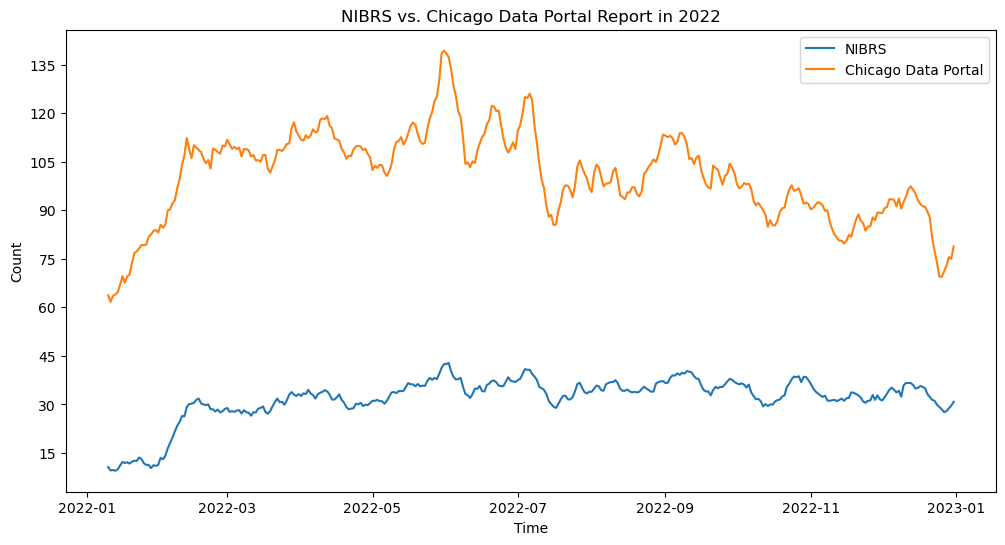

In [16]:
from matplotlib.ticker import MaxNLocator

# Plot report frequencies of NIBRS vs. Chicago Data Portal in 2022 (rolling average)
plt.figure(figsize=(12, 6))
plt.plot(nibrs_count['Time'], nibrs_count['Count'].rolling(10).mean(), label='NIBRS')
plt.plot(chicago_count['Time'], chicago_count['Count'].rolling(10).mean(), label='Chicago Data Portal')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('NIBRS vs. Chicago Data Portal Report in 2022')
plt.legend()
plt.savefig('chicago_volume.png', bbox_inches='tight')
plt.show()

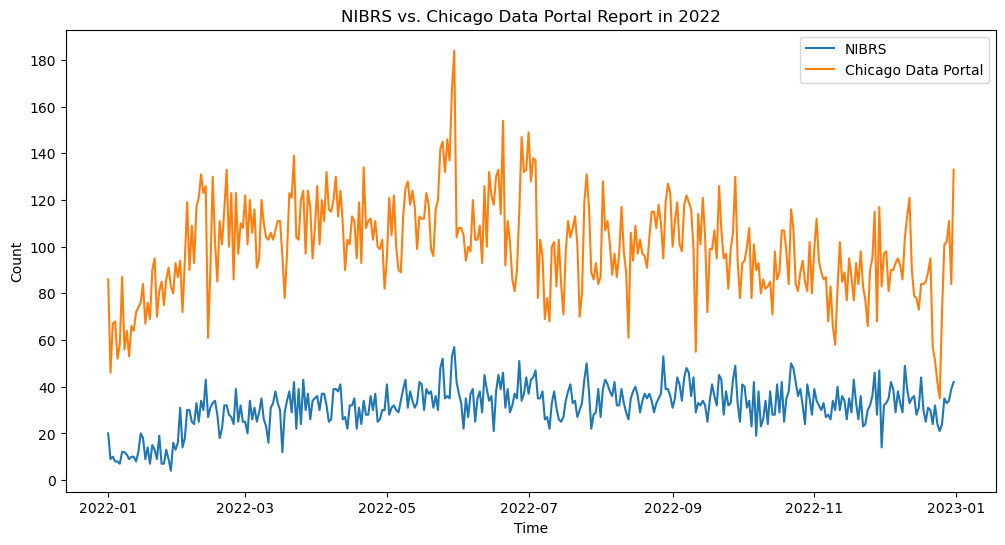

In [17]:
# Plot report frequencies of NIBRS vs. Chicago Data Portal in 2022
plt.figure(figsize=(12, 6))
plt.plot(nibrs_count['Time'], nibrs_count['Count'], label='NIBRS')
plt.plot(chicago_count['Time'], chicago_count['Count'], label='Chicago Data Portal')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('NIBRS vs. Chicago Data Portal Report in 2022')
plt.legend()
plt.show()

In [18]:
# Get correlations
combined_counts = nibrs_count.rename(
    columns={'Count': 'NIBRS'}
).merge(
    chicago_count.rename(
        columns={'Count': 'Chicago'}
    )
).set_index('Time')

combined_counts.corr()

,NIBRS,Chicago
NIBRS,1.000000,0.574959
Chicago,0.574959,1.000000


In [19]:
# Count unique cases
chicago_incident['CASE NUMBER'].nunique()

24437

In [20]:
# Get a list of unique offenses in Chicago
unique_chicago_offenses = chicago_incident['CHARGE 1 DESCRIPTION'].dropna().str.lower().unique().tolist()
unique_chicago_offenses

['domestic battery/bodily harm',
 'crim trespass to residence',
 'criminal trespass to land',
 'pcs - possession - poss amt con sub except (a)(d)',
 'crim damage to property <$500',
 'issuance of warrant',
 'pcs - mfg - possess any substance w/intent',
 'domestic battery - physical contact',
 'domestic battery - bodily harm',
 'ivc - driving under influence of alcohol',
 'battery - cause bodily harm',
 'cannabis - mfg/del - less than 2.5 grms',
 'armed habitual criminal',
 'assault - simple',
 'drinking alcohol on the public way',
 'theft/unauthorized con/$500',
 'unlwfl poss cannabis/driver',
 'violate order protection',
 'escape - from peace officer - misdemeanor',
 'reckless conduct',
 'agg uuw/vehicle/loaded/no fcca',
 'agg battery/peace officer',
 'driving on revoked license',
 'poss can/>10-30 grams/1st',
 'receive/possess/sell  stolen vehicle',
 'driving on suspended license',
 'resisting/obstruct/pc off/corr emp/frftr',
 'agg uuw/person/no foid',
 'battery - make physical conta

In [21]:
# Count the total number of unique offenses in Chicago
len(unique_chicago_offenses)

801

In [22]:
# Search the UCR offense codes in the NIBRS codebook
codebook = pd.read_excel(CODEBOOK_PATH, sheet_name='Incident Extract').ffill()
codebook = codebook[codebook['Variable Name'] == 'V20061']

# Create the mapping dictionary
mapper = dict(zip(codebook['Value'], codebook['Value Label']))
mapper

{91: 'Murder/Nonnegligent Manslaughter',
 92: 'Negligent Manslaughter',
 93: 'Justifiable Homicide',
 100: 'Kidnaping/Abduction',
 111: 'Rape',
 112: 'Sodomy',
 113: 'Sexual Assault With An Object',
 114: 'Fondling (Indecent Liberties/Child Molesting)',
 120: 'Robbery',
 131: 'Aggravated Assault',
 132: 'Simple Assault',
 133: 'Intimidation',
 200: 'Arson',
 210: 'Extortion/Blackmail',
 220: 'Burglary/Breaking and Entering',
 231: 'Pocket-picking',
 232: 'Purse-snatching',
 233: 'Shoplifting',
 234: 'Theft From Building',
 235: 'Theft From Coin-Operated Machine or Device',
 236: 'Theft From Motor Vehicle',
 237: 'Theft of Motor Vehicle Parts/Accessories',
 238: 'All Other Larceny',
 240: 'Motor Vehicle Theft',
 250: 'Counterfeiting/Forgery',
 261: 'False Pretenses/Swindle/Confidence Game',
 262: 'Credit Card/Automatic Teller Machine Fraud',
 263: 'Impersonation',
 264: 'Welfare Fraud',
 265: 'Wire Fraud',
 266: 'Identity Theft',
 267: 'Hacking/Computer Invasion',
 270: 'Embezzlement',


In [23]:
# Replace the values in 'V20061-UCR OFFENSE CODE - 1' with the UCR descriptions
chicago_incident_nibrs['V20061-UCR OFFENSE CODE - 1'] = chicago_incident_nibrs['V20061-UCR OFFENSE CODE - 1'].map(mapper)
unique_nibrs_offenses = chicago_incident_nibrs['V20061-UCR OFFENSE CODE - 1'].dropna().str.lower().unique().tolist()
unique_nibrs_offenses

['burglary/breaking and entering',
 'simple assault',
 'weapon law violations',
 'aggravated assault',
 'intimidation',
 'impersonation',
 'drug/narcotic violations',
 'kidnaping/abduction',
 'all other larceny',
 'stolen property offenses',
 'robbery',
 'sodomy',
 'purse-snatching',
 'theft from motor vehicle',
 'shoplifting',
 'destruction/damage/vandalism of property',
 'counterfeiting/forgery',
 'embezzlement',
 'theft from building',
 'sexual assault with an object',
 'murder/nonnegligent manslaughter',
 'drug equipment violations',
 'false pretenses/swindle/confidence game',
 'arson',
 'theft of motor vehicle parts/accessories',
 'rape',
 'theft from coin-operated machine or device',
 'animal cruelty',
 'motor vehicle theft',
 'fondling (indecent liberties/child molesting)',
 'betting/wagering',
 'identity theft',
 'extortion/blackmail']

In [24]:
from sentence_transformers import SentenceTransformer

# Use a transformer model to embed texts as matrices
st_model = SentenceTransformer(model_name_or_path='sentence-transformers/all-MiniLM-L6-v2')

chicago_embeddings = st_model.encode(unique_chicago_offenses)
nibrs_embeddings = st_model.encode(unique_nibrs_offenses)

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# Use cosine similarity to compare offense descriptions
embedding_array = cosine_similarity(
    nibrs_embeddings,
    chicago_embeddings,
)

sim_df = pl.DataFrame(
    embedding_array,
    schema=unique_chicago_offenses,
).with_columns(
    pl.Series(name='NIBRS Descriptions', values=unique_nibrs_offenses)
).melt(
    id_vars='NIBRS Descriptions',
    variable_name='Chicago Descriptions',
    value_name='Cosine Similarity'
).sort(
    'Cosine Similarity',
    descending=True,
)

sim_df

NIBRS Descriptions,Chicago Descriptions,Cosine Similarity
str,str,f32
"""robbery""","""robbery""",1.0
"""animal cruelty""","""animal - cruelty to animals""",0.957611
"""simple assault""","""assault - simple""",0.949998
"""simple assault""","""assault - simple (attempt)""",0.892818
"""robbery""","""robbery (attempt)""",0.887424
…,…,…
"""betting/wagering""","""driver's license/permit - fail…",-0.131291
"""animal cruelty""","""carry concealed fir/airport""",-0.133454
"""betting/wagering""","""carry concealed fir/airport""",-0.13697


In [26]:
# Create a dictionary with Boston descriptions as keys and NIBRS descriptions as values
# Group by 'Chicago Descriptions' and take the first row for each group (highest similarity)
chicago_nibrs_dict = sim_df.group_by(
    'Chicago Descriptions',
    maintain_order=True,
).agg(
    pl.col('NIBRS Descriptions').first()
).to_pandas().set_index(
    'Chicago Descriptions'
).to_dict()['NIBRS Descriptions']

# Display the resulting dictionary
chicago_nibrs_dict

{'robbery': 'robbery',
 'animal - cruelty to animals': 'animal cruelty',
 'assault - simple': 'simple assault',
 'assault - simple (attempt)': 'simple assault',
 'robbery (attempt)': 'robbery',
 'residential arson': 'arson',
 'identity theft/knows id stolen': 'identity theft',
 'identity theft/<$300': 'identity theft',
 'aggravated cruelty to animals': 'animal cruelty',
 'identity theft/$2k-$10k': 'identity theft',
 'identity theft/$300-$2000': 'identity theft',
 'intimidation - commit any criminal offense': 'intimidation',
 'identity theft/$10k-$100k': 'identity theft',
 'aggravated assault/public prop': 'aggravated assault',
 'residential arson              (attempt)': 'arson',
 'robbery - armed w/ firearm': 'robbery',
 'financial institution robbery': 'robbery',
 'robbery - armed w/ firearm (attempt)': 'robbery',
 'burglary': 'burglary/breaking and entering',
 'damage to public property': 'destruction/damage/vandalism of property',
 'criminal sex assault/consent': 'sexual assault wi

In [27]:
# Output the dictionary to a JSON file
with open('chicago_NIBRS_similarity.json', 'w') as fout:
    json.dump(chicago_nibrs_dict, fout, indent=4)

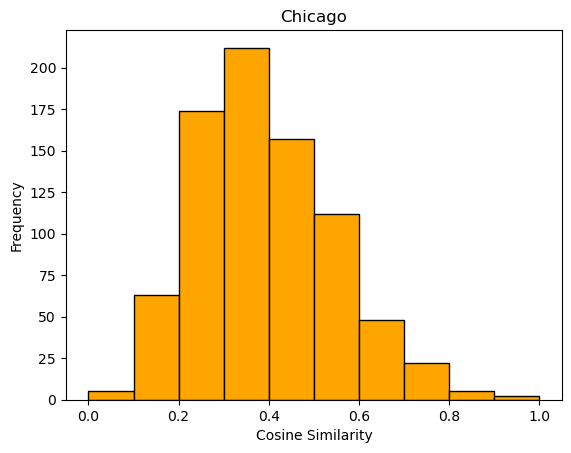

In [28]:
# Visualize the distribution of offense descriptions' cosine similarity
hist_data = sim_df.group_by(
    'Chicago Descriptions',
    maintain_order=True,
).agg(
    pl.col('NIBRS Descriptions').first(),
    pl.col('Cosine Similarity').first()
).to_pandas()['Cosine Similarity']

# Plotting the histogram
hist_data.plot(
    kind='hist',
    bins=np.arange(0, 1.01, 0.1),
    color='orange',
    edgecolor='k'
)

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Chicago')
plt.savefig('chicago_cos_sim.png', bbox_inches='tight')
plt.show()